# Ciclo 1 - Data Descrip / Descrip Statistics / Feat Engineering / D Filter

## Business Problem

#### Objetivo do problema

-- Previsão do primeiro destino que um novo usuario irá escolher

#### Porque?

##### Qual tipo de modelo de negócio do AirBNB?

-- MarketPlace (Conecta pessoas que oferecem acomodações, com pessoas que estão procurando acomodação).

##### Oferta (Pessoas oferecendo acomodação)

-- Tamanho do portfólio
-- Diversidade / densidade de portfólio
-- Preço médio

##### Demanda (Pessoas procurando acomodação)

-- Número de usuarios
-- LTV (Lifitime Value)
-- CAC (Client Acquisition Cost)
-- Cross Revenue ( FEE * Numero Cliente) - CAC

##### Proposta da Solução

-- Modelo de predição do primeiro destino de um novo usuario

##### Tipos de formatos para entrega do projeto

-- Predições salva em tabela do banco de dados.
-- API: Input: Usuario e suas caracteristicas / Output: Usuarios e suas caracteristicas com as predições do destino.

|Feature Name| Information|
|----------------|:---------------:|
|id:                         |ID do Usuario
|date_account_created:       |Data da Criação da Conta
|timestamp_first_active:     |Data do primeira acesso, note que pode ser anterior à data de criação da conta ou à data da primeira reserva porque um utilizador pode pesquisar antes de se inscrever
|date_first_booking:         |data da primeira reserva
|gender                      |Sexo
|age                         |Idade 
|signup_method               |Metodo de inscrição
|signup_flow:                |fluxo de inscrição: a página de onde um utilizador veio para se inscrever
|language:                   |Preferencia linguistica internacional
|affiliate_channel:          |canal afiliado: que tipo de marketing pago
|affiliate_provider:         |fornecedor afiliado: onde o marketing é, por exemplo, google, craigslist, outro
|first_affiliate_tracked:    |primeira afiliação rastreada: qual foi o primeiro marketing com que o utilizador interagiu antes da inscrição
|signup_app                  |Aplicativo de inscrição
|first_device_type           |Primeiro tipo de dispositivo
|first_browser               |Primeiro nagevagor
|country_destination:        |Destino do pai:Variavel alvo que deve prever

## 0.0 - Imports

In [164]:
import pandas as pd
import random
import numpy as np
from scipy import stats
import missingno as miss

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt

from keras import models as ml
from keras import layers as l

#Balanced dataset
from imblearn import under_sampling as us  #Random Undersampling
from imblearn import over_sampling as over #Random Oversampling
from imblearn import combine as c          #SMOTE + TOMELINK

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [165]:
#Paths
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_booking_final/airnbn_predict_first-booking-/data/'
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_booking_final/airnbn_predict_first-booking-/models/'

### Functions

In [166]:
def drescriptive_statistical (df):

    num_atributes = df.copy()
    #Central Tendency - mean - median
    ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

    #Dispersion - STD, min, max, range, sken, Kurtosis
    d1 = pd.DataFrame(num_atributes.apply(np.std)).T
    d2 = pd.DataFrame(num_atributes.apply(min)).T
    d3 = pd.DataFrame(num_atributes.apply(max)).T
    d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis() )).T

    #Concatenate

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()


#Function Calculates cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1) / (n - 1))
    kcorr = k - (k - 1) **2/(n - 1) 
    rcorr = r - (r - 1) **2/(n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr -1) ) )

### Loading Data

### Data Sessions

In [167]:
session = pd.read_csv(path_data+'sessions.csv')

In [168]:
session.head(1).T

,0
user_id,d1mm9tcy42
action,lookup
action_type,NaN
action_detail,NaN
device_type,Windows Desktop
secs_elapsed,319.0


In [169]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [170]:
session.user_id.value_counts().head()
#Ja podemos notar que temos repetição para o mesmo user id

mxqbh3ykxl    2722
0hjoc5q8nf    2644
mjbl6rrj52    2476
l5lgm3w5pc    2424
wg9413iaux    2362
Name: user_id, dtype: int64

## 1.0 Data Description and Cleaning

In [171]:
#Data Dimensions

print('Number of Rows: {}'.format(session.shape[0]))
print('Number of Columns: {}'.format(session.shape[1]))

Number of Rows: 10567737
Number of Columns: 6


In [172]:
# Data Types

session.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

#### Check NA Session

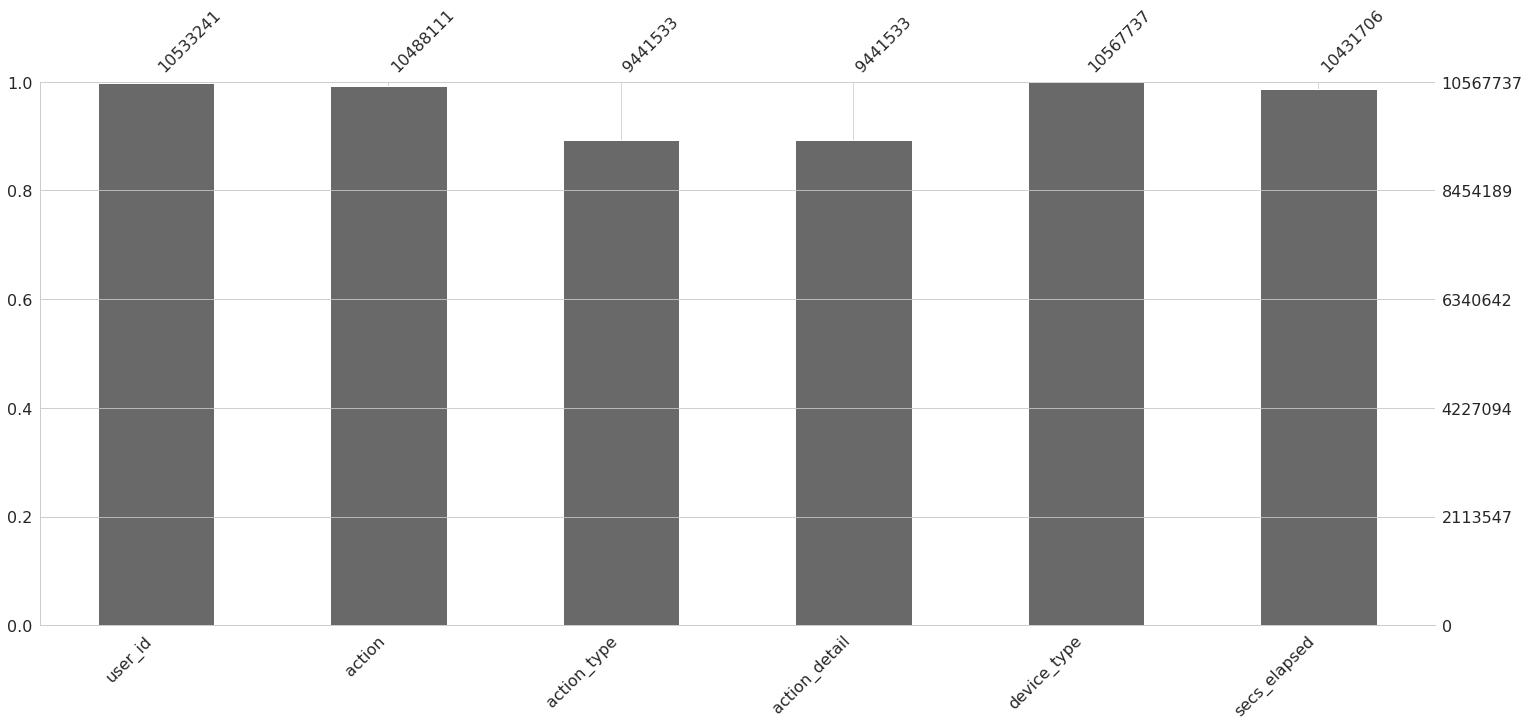

In [173]:
miss.bar(session)
sns.despine()

In [174]:
#Para os NAs estou assumindo a alteração pela moda de cada coluna exceto para a coluna secs_elapsed, nesta colo o valor 0

session['action'].fillna(session['action'].mode()[0], inplace=True)
session['action_type'].fillna(session['action_type'].mode()[0], inplace=True)
session['action_detail'].fillna(session['action_detail'].mode()[0], inplace=True)
session['device_type'].fillna(session['device_type'].mode()[0], inplace=True)
session['secs_elapsed'].fillna(0, inplace=True)

#Replace no espaço com _ no device_type
session.device_type = session.device_type.str.replace(' ', '_')

In [175]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,view,view_search_results,Windows_Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows_Desktop,67753.0
2,d1mm9tcy42,lookup,view,view_search_results,Windows_Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows_Desktop,22141.0
4,d1mm9tcy42,lookup,view,view_search_results,Windows_Desktop,435.0


In [176]:
#Removendo valor nulo do user_id

session = session[pd.isnull(session.user_id) == False]

In [177]:
session.shape

(10533241, 6)

In [178]:
#Adicionando espaço para conseguir mesclar em uma linha

session['action'] = [' ' + i + ' ' for i in session['action']]
session['action_type'] = [' ' + i + ' ' for i in session['action_type']]
session['action_detail'] = [' ' + i + ' ' for i in session['action_detail']]

In [179]:
user_id = list(set(session['user_id'].values))
len(user_id)

135483

In [180]:
#Pegando valor medio de ucada usuario especifico

sec_e = session.groupby('user_id', sort=False,)[['secs_elapsed']].mean()
sec_e.count()

secs_elapsed    135483
dtype: int64

In [181]:
#Gerando nova sessão para cada ID com apenas uma linha

action = session.groupby('user_id', sort=False)[['action']].sum()
action_type = session.groupby('user_id', sort=False)[['action_type']].sum()
action_detail = session.groupby('user_id', sort=False)[['action_detail']].sum()

In [182]:
#Criando novo Data Frame com as novas sessoes usando o agrupamento 

new_session = pd.DataFrame(user_id, columns=['user_id'])
new_session['action'] = action['action'].values
new_session['action_type'] = action_type['action_type'].values
new_session['action_detail'] = action_detail['action_detail'].values
new_session['secs_elapsed'] = sec_e['secs_elapsed'].values

new_session

,user_id,action,action_type,action_detail,secs_elapsed
0,z88g0vqsco,lookup search_results lookup search_result...,view click view click view click view ...,view_search_results view_search_results vie...,26988.417323
1,mnabvin0n9,dashboard create confirm_email show show_...,view submit click view data view data ...,dashboard create_user confirm_email_link p...,23093.555556
2,chpav7trz2,verify create show pending requested hea...,-unknown- submit message_post booking_requ...,-unknown- create_user message_post pending...,70965.250000
3,4lr5irgqwf,lookup show search_results search_results ...,view view click click view view click ...,view_search_results p3 view_search_results ...,24704.605263
4,1udpn6x3ex,campaigns active create notifications lis...,-unknown- -unknown- -unknown- -unknown- -...,-unknown- -unknown- -unknown- -unknown- -...,319.375000
...,...,...,...,...,...
135478,ljdegur3yc,confirm_email authenticate index header_us...,click submit view data submit submit da...,confirm_email_link login your_listings hea...,27249.806452
135479,ryki0mlixl,index campaigns collections active show ...,view view view -unknown- view view view...,view_reservations view_search_results user_...,2580.900000
135480,7qkjinozte,index my index search_results search_resu...,view view view click click click click ...,view_search_results user_wishlists user_wis...,10555.089744
135481,e2ogmhv2w5,show update create personalize header_use...,view submit -unknown- data data submit ...,view_search_results update_listing -unknown...,23471.200000


In [183]:
new_session.shape

(135483, 5)

### Data Train_users

In [184]:
train = pd.read_csv(path_data+'train_users_2.csv')

In [185]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [186]:
#Data Dimensions

print('Number of Rows: {}'.format(train.shape[0]))
print('Number of Columns: {}'.format(train.shape[1]))

Number of Rows: 213451
Number of Columns: 16


In [187]:
#Renomeando o ID
train.rename(columns={'id': 'user_id'}, inplace=True)
train.head(2)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


#### Check NA

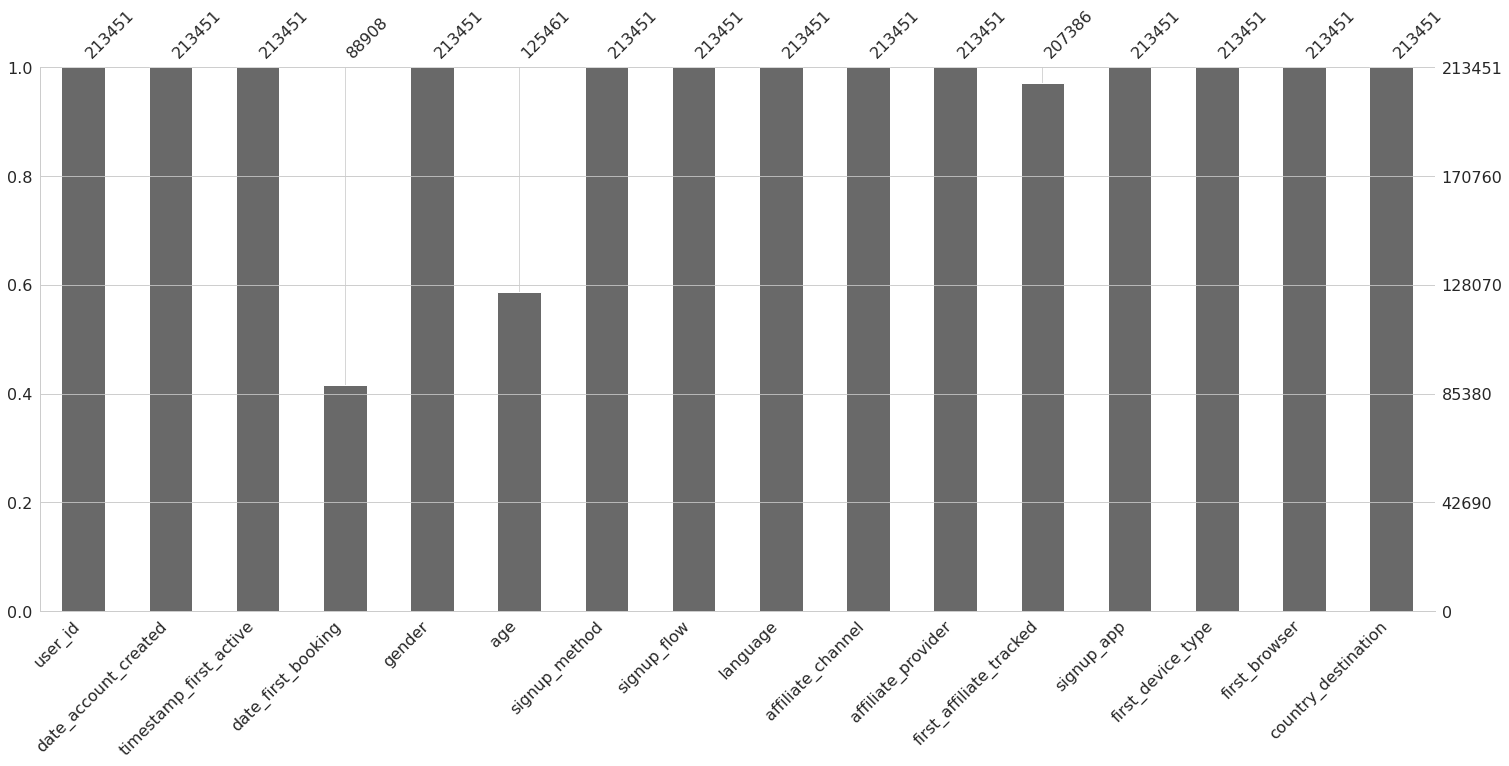

In [188]:
miss.bar(train)
sns.despine()

In [189]:
train.isna().sum() / len(train)

user_id                    0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

#### Date_first_booking

In [190]:
# Temos Quase 60% dos dados faltantes nessa coluna, os dados faltantes representa apenas uma classe da variavel resposta (Sem destino definido)
# Para preservar os dados e se estivesse trabalhando na AIRBNB colocaria a data atual, pois neste caso todos os dias os dados seriam atualizados para o dia atual.
# Quando o cliente entrou no site até hoje teria x dias que ele ainda não fez o book. Dessa forma seria calculado essa quantidade de dias como features.
# Como esses dados não estão atualizados, estou pegando a ultima data que temos de informação na coluna e adicionando para os dados faltantes 

# Tratamento dos NAs da coluna date_first_booking
aux = train[train['date_first_booking'].isna()]
aux['country_destination'].value_counts(normalize=True)

#Transformando os NAs na data maxima do date_first_booking
date_first_booking_max = pd.to_datetime(train['date_first_booking']).max().strftime('%Y-%m-%d')
train.date_first_booking = train['date_first_booking'].fillna(date_first_booking_max)


#### Age

In [191]:
train.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [192]:
aux_age = train[train['age'].isna()]
print(aux_age['country_destination'].value_counts(normalize=True))
#Existe uma distribuição entre a idade NAs em relação a classe procurada.

#Estarei adicionado a media da idade para idade acima de 95 e menor que 16. Assumindo que pessoas acima de 95 anos dificilmente conseguem realizar reserva e menores de 16
#anos tambem.

train.loc[train['age'] > 120, 'age'] = np.nan
train.loc[train['age'] < 16, 'age'] = np.nan

train.loc[train['age'].isnull(), 'age'] = train.age.median()


NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64


<AxesSubplot:xlabel='age', ylabel='Density'>

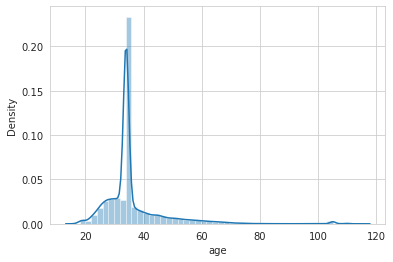

In [193]:
sns.distplot(train.age)

#### First_affiliate_tracked

In [194]:
#Os NAs dessa coluna representa apenas 2% do total dos dados, neste caso estarei excluindo todos os NAs.

train = train[~train['first_affiliate_tracked'].isna()]

In [195]:
train.isna().sum()

user_id                    0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

### Data Types

In [196]:
train.dtypes

user_id                     object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### Tratamento nos tipos das colunas

In [197]:
train.head(1)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,2015-06-29,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF


In [198]:
#date_acount_created
train.date_account_created = pd.to_datetime(train.date_account_created)

#Timestamp_first_active
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format='%Y%m%d%H%M%S')
train.timestamp_first_active = pd.to_datetime(train.timestamp_first_active.dt.strftime('%Y-%m-%d'))

#data_first_booking
train.date_first_booking = pd.to_datetime(train.date_first_booking)

#age
train.age = train.age.astype(int)


#Limpeza e ajustes nos dados

train['first_device_type'] = [s.replace(' ', '_') for s in train.first_device_type]
train['first_device_type'] = [s.replace('/', '_') for s in train.first_device_type]
train['first_device_type'] = [s.replace('(', '') for s in train.first_device_type]
train['first_device_type'] = [s.replace(')', '') for s in train.first_device_type]
train['affiliate_channel'] = [s.replace('-', '_') for s in train.affiliate_channel]
train['affiliate_provider']= [s.replace('-', '_') for s in train.affiliate_provider]
train['first_browser']     = [s.replace('-', '') for s in train.first_browser]
train['first_browser']     = [s.replace(' ', '_') for s in train.first_browser]
train['first_browser']     = [s.replace('.', '_') for s in train.first_browser]
train['gender']            = [s.replace('-', '') for s in train.gender]

In [199]:
train.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [200]:
train.head(1)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19,2015-06-29,unknown,34,facebook,0,en,direct,direct,untracked,Web,Mac_Desktop,Chrome,NDF


### Dataset Train_user Final

In [201]:
#Juntando dataset session com o dataset treino.
new_train = train.set_index('user_id').join(new_session.set_index('user_id'), how='inner', on='user_id').reset_index()
new_train.head(1)

#Data Dimensions

print('Number of Rows: {}'.format(new_train.shape[0]))
print('Number of Columns: {}'.format(new_train.shape[1]))

Number of Rows: 73513
Number of Columns: 20


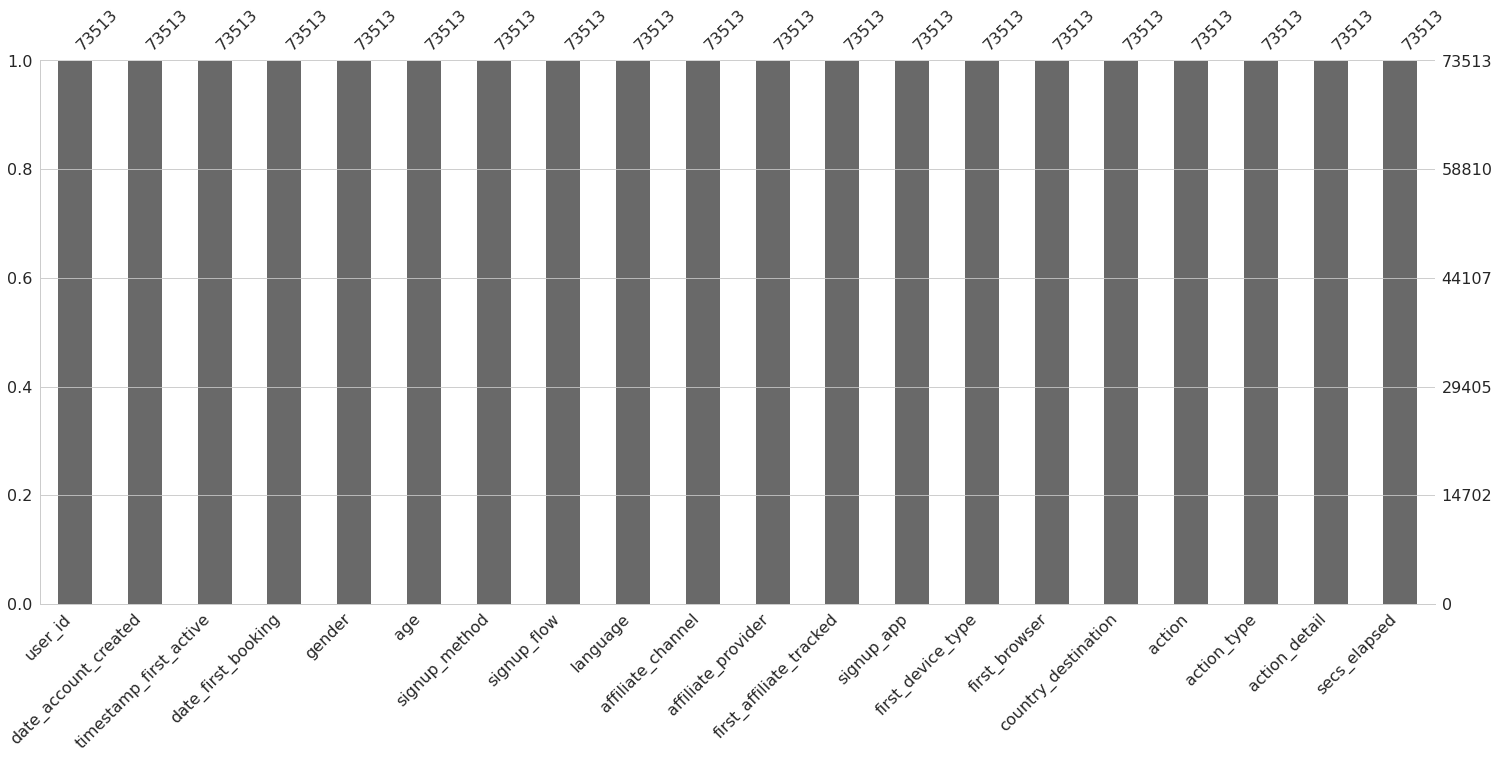

In [202]:
miss.bar(new_train)
sns.despine()

In [203]:
new_train.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
action                             object
action_type                        object
action_detail                      object
secs_elapsed                      float64
dtype: object

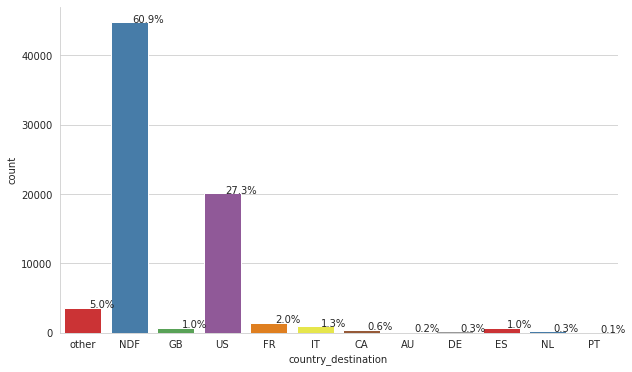

In [204]:
#Chack Balanced Data

plt.figure(figsize = (10, 6))
ax = sns.countplot(x='country_destination', data=new_train, palette='Set1')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / new_train.shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
sns.despine()


### Data test_users

In [205]:
data = pd.read_csv(path_data+'test_users.csv')
data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [206]:
#Data Dimensions
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Columns: {}'.format(data.shape[1]))

Number of Rows: 62096
Number of Columns: 15


In [207]:
#Renomeando o ID
data.rename(columns={'id': 'user_id'}, inplace=True)
data.head(2)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari


#### Check NA

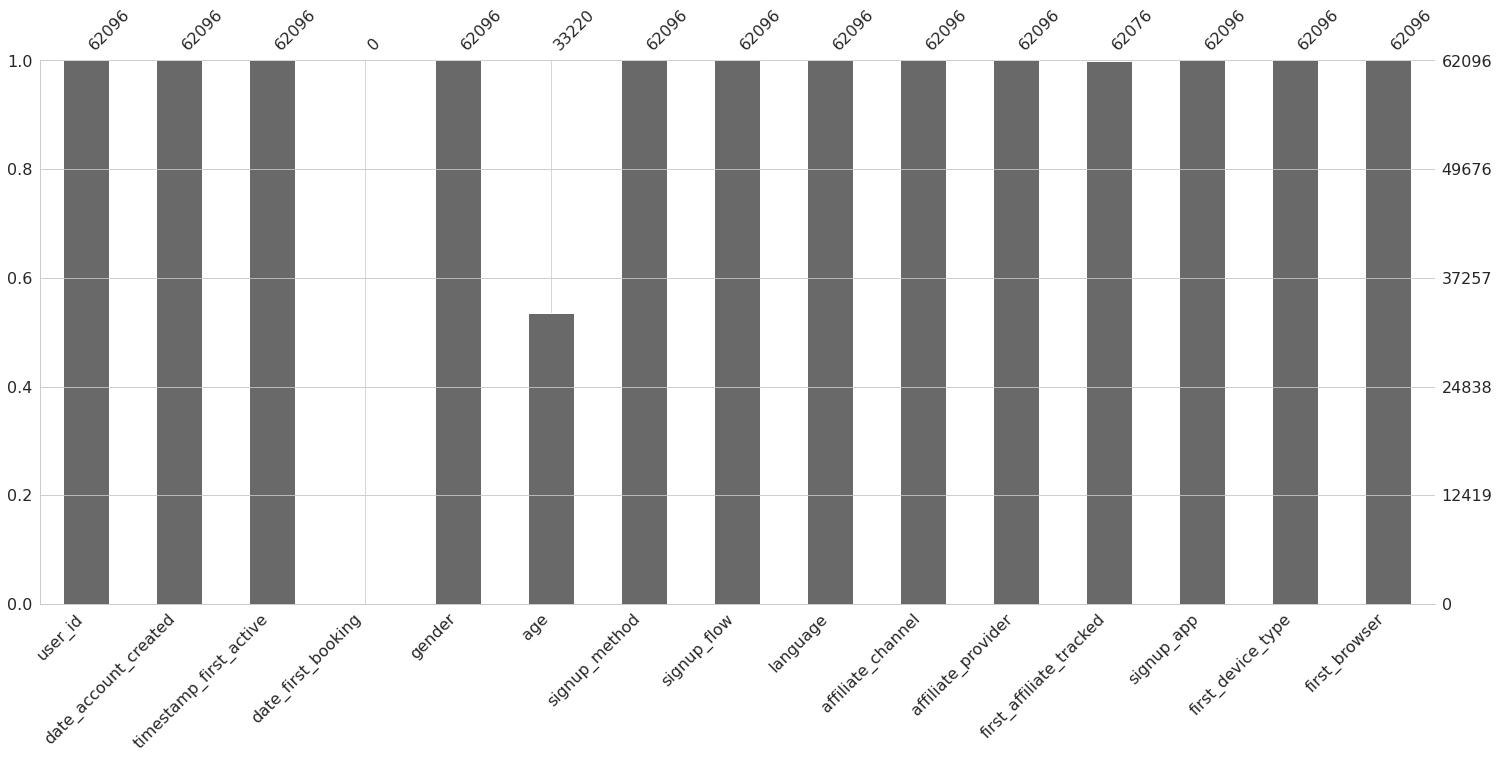

In [208]:
miss.bar(data)
sns.despine()

In [209]:
data.isna().sum() / len(data)

user_id                    0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         1.000000
gender                     0.000000
age                        0.465022
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.000322
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
dtype: float64

#### Date_first_booking

In [210]:
#Nesta coluna temos 100% NAs, pois como são dados de teste não teremos nenhum cliente que ja
#tenha feito o primeiro book.
#Neste caso iremos excluir essa coluna.

data = data.drop('date_first_booking', axis=1)

### Age

In [211]:
data.age.describe()

count    33220.000000
mean        37.616677
std         74.440647
min          1.000000
25%         26.000000
50%         31.000000
75%         40.000000
max       2002.000000
Name: age, dtype: float64

In [212]:
aux1_age = data[data['age'].isna()]

#Estarei adicionado a media da idade para idade acima de 95 e menor que 16. Assumindo que pessoas acima de 95 anos dificilmente conseguem realizar reserva e menores de 16
#anos tambem.

data.loc[data['age'] > 120, 'age'] = np.nan
data.loc[data['age'] < 16, 'age'] = np.nan

data.loc[data['age'].isnull(), 'age'] = train.age.median()


<AxesSubplot:xlabel='age', ylabel='Density'>

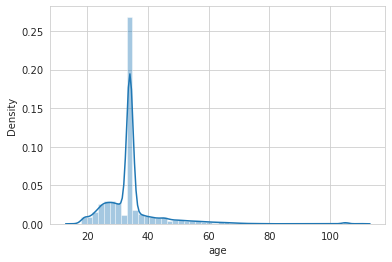

In [213]:
sns.distplot(data.age)

### First_affiliate_tracked

In [214]:
#Os NAs dessa coluna representa apenas 2% do total dos dados, neste caso estarei excluindo todos os NAs.

data = data[~data['first_affiliate_tracked'].isna()]

In [215]:
data.isna().sum()

user_id                    0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
dtype: int64

In [216]:
data.dtypes

user_id                     object
date_account_created        object
timestamp_first_active       int64
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
dtype: object

### Tratamento nos tipos das colunas

In [217]:
data.head(1)

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari


In [218]:
#data_acount_created
data.date_account_created = pd.to_datetime(data.date_account_created)

#timestamp_first_active
data['timestamp_first_active'] = pd.to_datetime(data['timestamp_first_active'], format='%Y%m%d%H%M%S')
data.timestamp_first_active = pd.to_datetime(data.timestamp_first_active.dt.strftime('%Y-%m-%d'))

#data_first_booking
data.age = data.age.astype(int)

#Tratamento e ajustes nos dados
data['first_device_type'] = [s.replace(' ', '_') for s in data.first_device_type]
data['first_device_type'] = [s.replace('/', '_') for s in data.first_device_type]
data['first_device_type'] = [s.replace('(', '') for s in  data.first_device_type]
data['first_device_type'] = [s.replace(')', '') for s in  data.first_device_type]
data['affiliate_channel'] = [s.replace('-', '_') for s in data.affiliate_channel]
data['affiliate_provider']= [s.replace('-', '_') for s in data.affiliate_provider]
data['first_browser']     = [s.replace('-', '') for s in  data.first_browser]
data['first_browser']     = [s.replace(' ', '_') for s in data.first_browser]
data['first_browser']     = [s.replace('.', '_') for s in data.first_browser]
data['gender']            = [s.replace('-', '') for s in  data.gender]

In [219]:
data.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
dtype: object

In [220]:
data.head(1)

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01,FEMALE,35,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile_Safari


### Dataset Test_user Final

In [221]:
#Juntando dataset session com o dataset treino.

new_test = data.set_index('user_id').join(new_session.set_index('user_id'), how='inner', on='user_id').reset_index()
new_test.head(1)

#Data Dimensions

print('Number of Rows: {}'.format(new_test.shape[0]))
print('Number of Columns: {}'.format(new_test.shape[1]))

Number of Rows: 61662
Number of Columns: 18


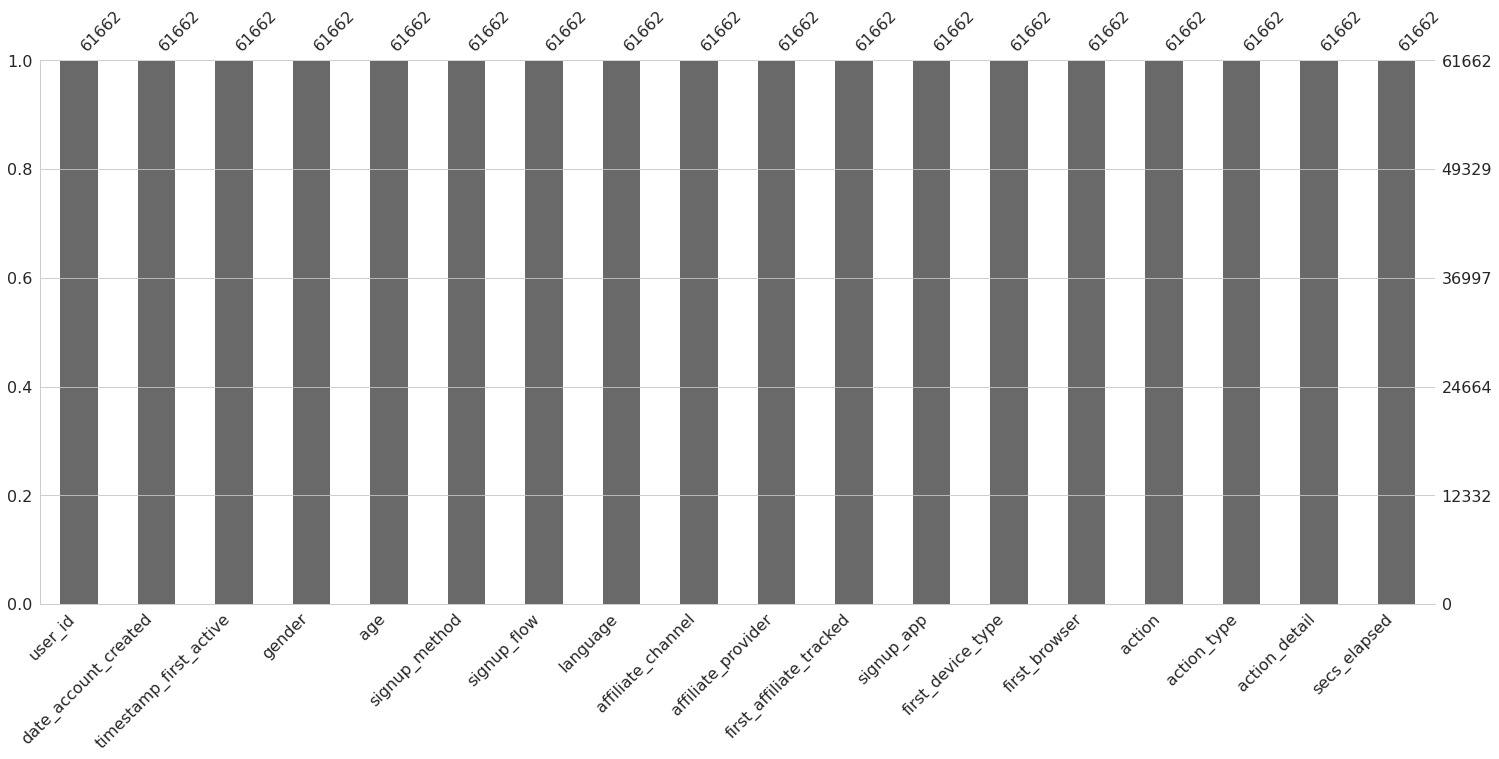

In [222]:
miss.bar(new_test)
sns.despine()

In [223]:
new_test.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
action                             object
action_type                        object
action_detail                      object
secs_elapsed                      float64
dtype: object

In [224]:
print('Number of Rows test: {}'.format(new_test.shape[0]))
print('Number of Columns test: {}'.format(new_test.shape[1]))
print('--------------------------------------------------')
print('Number of Rows train: {}'.format(new_train.shape[0]))
print('Number of Columns train: {}'.format(new_train.shape[1]))
print('------------------------------------------')

Number of Rows test: 61662
Number of Columns test: 18
--------------------------------------------------
Number of Rows train: 73513
Number of Columns train: 20
------------------------------------------


## 2.0 Descriptive Statistics

In [225]:
num_atributes_train = new_train.select_dtypes(include=['int64', 'float64'])
cat_atributes_train = new_train.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

num_atributes_test = new_test.select_dtypes(include=['int64', 'float64'])
cat_atributes_test = new_test.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 2.1 Numerical Atributes

In [226]:
drescriptive_statistical(num_atributes_train)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.000000,99.000000,35.247494,34.000000,10.732398,3.150632,15.39974
1,signup_flow,0.0,25.000000,25.000000,4.798104,0.000000,9.304551,1.535172,0.51084
2,secs_elapsed,0.0,889989.666667,889989.666667,25887.197846,15975.736641,37801.032792,6.950030,84.01801


In [227]:
drescriptive_statistical(num_atributes_test)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,110.000000,94.000000,34.437611,34.000000,9.633277,3.028002,16.290207
1,signup_flow,0.0,25.000000,25.000000,7.796358,0.000000,11.247423,0.793937,-1.319196
2,secs_elapsed,0.0,931358.666667,931358.666667,25921.155417,16160.079067,37172.617270,6.807657,81.895139


-- Anomalias detectado

--> signup_flow com registro zerado

--> secs_elapsed tambem com registro zerado

### 2.2 Cat Atributes

In [228]:
cat_atributes_train.describe().T

,count,unique,top,freq
user_id,73513,73513,d1mm9tcy42,1
gender,73513,4,unknown,37617
signup_method,73513,3,basic,54963
language,73513,24,en,70813
affiliate_channel,73513,8,direct,46647
affiliate_provider,73513,17,direct,46647
first_affiliate_tracked,73513,7,untracked,39049
signup_app,73513,4,Web,57011
first_device_type,73513,9,Mac_Desktop,28029
first_browser,73513,35,Chrome,22662


In [230]:
cat_atributes_test.describe().T

,count,unique,top,freq
user_id,61662,61662,5uwns89zht,1
gender,61662,4,unknown,33495
signup_method,61662,4,basic,44976
language,61662,24,en,58814
affiliate_channel,61662,7,direct,43500
affiliate_provider,61662,17,direct,43500
first_affiliate_tracked,61662,7,untracked,33702
signup_app,61662,4,Web,36959
first_device_type,61662,9,iPhone,18903
first_browser,61662,31,unknown,16984


## 3.0 Feature Engineering

### Criação das Hipóteses

H01. Em todos os destinos, os usuarios levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativação

H02. Em todos os destino, os usuarios levam 3 dias, em media, para fazer o cadastro no site.

H03. O volume de reserva anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

H04. Usuarios do sexo Feminino fazem 10% mais reservas para paises fora do EUA.

H05. O canal de marketing google representa 40% das reservas para paises fora dos EUA

H06. O Destino dos USA representam mais de 20% em todos os canais

H07. A idade media das pessoas é de 35 anos em todos os destinos.

H08. A porcentagem de usuarios que usam o site n linhgua ingles-americanos para reservar acomodações em qualquer destino é maior que 90%.

H09. O Número de reserva do Airbnb é crescente ou decrescente ao longo dos anos

H10. O numero de reservas do Airbnb é crescente ao longo dos anos.

### Derivação de Novas Features

In [77]:
df_final.head(1).T

,0
user_id,d1mm9tcy42
date_account_created,2014-01-01 00:00:00
timestamp_first_active,2014-01-01 00:00:00
date_first_booking,2014-01-04 00:00:00
gender,MALE
age,62
signup_method,basic
signup_flow,0
language,en
affiliate_channel,sem_non_brand


In [78]:
#Days from first active up to first booking
df_final['date_first_booking_days'] = (df_final.date_first_booking - df_final.timestamp_first_active).apply(lambda x: x.days)
df_final['date_first_booking_days'] = (df_final.date_first_booking_days).apply(lambda x: 0 if x < 0 else x)

#Days From first active up to account created
df_final['date_account_created_days'] = (df_final.timestamp_first_active - df_final.date_account_created).apply(lambda x: x.days)
df_final['date_account_created_days'] = (df_final.date_account_created_days).apply(lambda x: 0 if x < 0 else x)

#Days from acount created up to first booking
df_final['date_account_created_util_booking_days'] = (df_final.date_first_booking - df_final.date_account_created).apply(lambda x: x.days)
df_final['date_account_created_util_booking_days'] = (df_final.date_account_created_util_booking_days).apply(lambda x: 0 if x < 0 else x)

#year
df_final['date_account_created_year']   = df_final.date_account_created.dt.year
df_final['timestamp_first_active_year'] = df_final.timestamp_first_active.dt.year
df_final['date_first_booking_year']     = df_final.date_first_booking.dt.year	

#month
df_final['date_account_created_month']   = df_final.date_account_created.dt.month
df_final['timestamp_first_active_month'] = df_final.timestamp_first_active.dt.month
df_final['date_first_booking_month']     = df_final.date_first_booking.dt.month

#Week
df_final['date_account_created_week']    = df_final.date_account_created.dt.weekday
df_final['timestamp_first_active_week']  = df_final.timestamp_first_active.dt.weekday
df_final['date_first_booking_week']      = df_final.date_first_booking.dt.weekday

#days
df_final['date_account_created_day']     = df_final.date_account_created.dt.day
df_final['timestamp_first_active_day']   = df_final.timestamp_first_active.dt.day
df_final['date_first_booking_year_day']  = df_final.date_first_booking.dt.day

In [79]:
df_final.head(1).T

,0
user_id,d1mm9tcy42
date_account_created,2014-01-01 00:00:00
timestamp_first_active,2014-01-01 00:00:00
date_first_booking,2014-01-04 00:00:00
gender,MALE
age,62
signup_method,basic
signup_flow,0
language,en
affiliate_channel,sem_non_brand


## 4.0 Data Filter

### 4.1 Filtering Rows

In [80]:
df_final = df_final[df_final['secs_elapsed'] > 0]
df_final.head()


,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,date_first_booking_year,date_account_created_month,timestamp_first_active_month,date_first_booking_month,date_account_created_week,timestamp_first_active_week,date_first_booking_week,date_account_created_day,timestamp_first_active_day,date_first_booking_year_day
0,d1mm9tcy42,2014-01-01,2014-01-01,2014-01-04,MALE,62,basic,0,en,sem_non_brand,...,2014.0,1,1,1.0,2,2,5.0,1,1,4.0
1,yo8nz8bqcq,2014-01-01,2014-01-01,2015-06-29,unknown,34,basic,0,en,direct,...,2015.0,1,1,6.0,2,2,0.0,1,1,29.0
2,4grx6yxeby,2014-01-01,2014-01-01,2015-06-29,unknown,34,basic,0,en,sem_brand,...,2015.0,1,1,6.0,2,2,0.0,1,1,29.0
3,ncf87guaf0,2014-01-01,2014-01-01,2015-06-29,unknown,34,basic,0,en,direct,...,2015.0,1,1,6.0,2,2,0.0,1,1,29.0
4,4rvqpxoh3h,2014-01-01,2014-01-01,2014-01-02,unknown,34,basic,25,en,direct,...,2014.0,1,1,1.0,2,2,3.0,1,1,2.0


### 4.2 Filtering Cols

In [81]:
# Excluindo as Datas

df_final = df_final.drop([ 'date_account_created', 'timestamp_first_active', 'date_first_booking'], axis=1)

### 4.3 Cat Atributes

In [82]:
#cat_atributes = cat_atributes.sample(20000)

#Cramers V

#rows = []

#for var1 in cat_atributes:
#    col = []
#    for var2 in cat_atributes:
#        cramers = cramer_v(cat_atributes[var1], cat_atributes[var2])
#        col.append(round(cramers, 2))
#    rows.append(col)

#cramers_result = np.array(rows)
#df = pd.DataFrame(cramers_result, columns=cat_atributes.columns, index=cat_atributes.columns)

#sns.set(rc= {'figure.figsize': (15, 10)})
#sns.heatmap(df, annot=True)

In [84]:
#Correlações
#signup_app x first_device_type
#first_browser X first_device_type

#Aproveitando que essa coluna esta com uma autocorrelação, vou excluir pois tambem ela tem umaaltar dimensionalidade.
df_final = df_final.drop('first_browser', axis=1)


In [85]:
#Separando os Datasets

new_test = df_final[df_final['country_destination'].isna()]
new_train = df_final[~df_final['country_destination'].isna()]


#new_test.to_csv(path_data+ 'final_test.csv', index=False)
#new_train.to_csv(path_data+ 'final_train.csv', index=False)

In [86]:
colums_drop = ['country_destination', 'date_first_booking_days', 'date_account_created_util_booking_days', 'date_first_booking_year', 'date_account_created_util_booking_days',
           'date_first_booking_year', 'date_first_booking_month', 'date_first_booking_week', 'date_first_booking_year_day']

new_test = new_test.drop(colums_drop, axis=1)

In [154]:
print('Number of Rows test: {}'.format(new_test.shape[0]))
print('Number of Columns test: {}'.format(new_test.shape[1]))
print('--------------------------------------------------')
print('Number of Rows train: {}'.format(new_train.shape[0]))
print('Number of Columns train: {}'.format(new_train.shape[1]))
print('------------------------------------------')
print('Number of Rows Join: {}'.format(df_final.shape[0]))
print('Number of Columns Join: {}'.format(df_final.shape[1]))

Number of Rows test: 61004
Number of Columns test: 24
--------------------------------------------------
Number of Rows train: 72689
Number of Columns train: 31
------------------------------------------
Number of Rows Join: 133693
Number of Columns Join: 31


# Ciclo 2 - EDA

## 6.0 Exploratory Data Analysis

In [155]:
train = pd.read_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_booking_final/airnbn_predict_first-booking-/data/train_users_2.csv')
final_train = pd.read_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_booking_final/airnbn_predict_first-booking-/data/final_train.csv')

train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### 6.1 Univariate Analysis on train data

#### Variavel Resposta

In [109]:
train['country_destination'].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

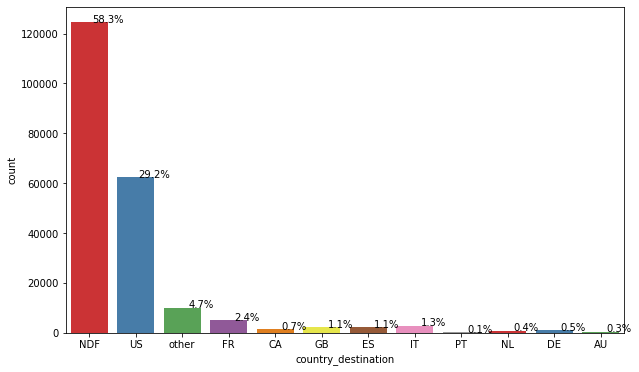

In [110]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="country_destination", data=train,palette='Set1')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/train.shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')

--> Acima, podemos ver que NDF (nenhum destino encontrado) está tendo a maior porcentagem como rótulo de classe, seguido por EUA e outros.

--> A maioria dos usuários se registrou e não reservou nenhuma viagem.

--> Embora, exceto NDF, a maioria dos usuários prefira viajar para os EUA.

--> Existem poucas porcentagens de pessoas que costumam viajar para outros países, como Itália, Espanha, Grã-Bretanha, etc.

Claramente temos um problema de classificação com os dados bem desbalanceado. Precisaremos utilizar algumas metricas de balaceamento conforme o problema de negócio.

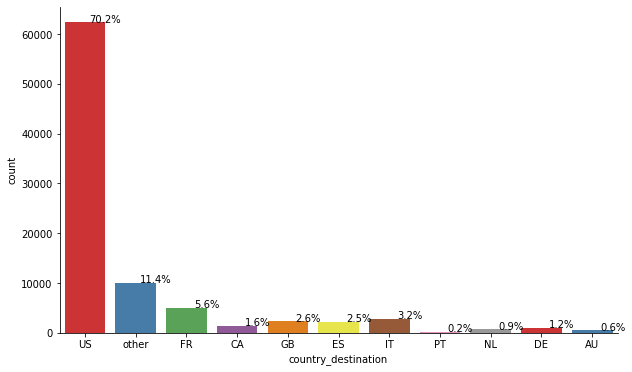

In [111]:
train1=train[train['country_destination']!='NDF']

plt.figure(figsize=(10,6))
ax = sns.countplot(x="country_destination", data=train1,palette='Set1')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/train1.shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
sns.despine()

--> Depois de excluir o rótulo de classe NDF, podemos ver que os EUA estão tendo cerca de 70% onde as pessoas usam para reservar uma viagem.

--> Cerca de 11% das pessoas costumam viajar para outros países que não fazem parte do rótulo da classe.

--> Poucas pessoas costumam viajar para a França depois dos EUA.

--> Outros países estão tendo uma porcentagem muito pequena de usuários.

#### Age

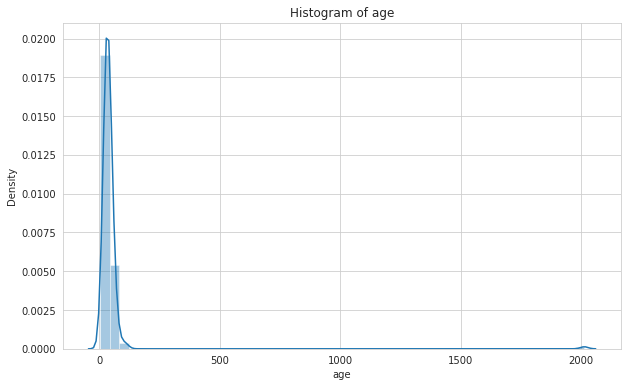

In [114]:
#Probability Density Function

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.distplot(train1['age'])
plt.title("Histogram of age")
plt.ylabel("Density")
plt.show()

--> Como podemos ver acima, a maioria dos valores está entre 0 e 100.

--> Existem muitos valores discrepantes com valores de idade superiores a 100 e o valor máximo de idade é 2014, o que pode ser que o usuário tenha inserido o ano no lugar da idade.

--> Estaremos removendo esses outliers e iremos visualizá-los novamente.

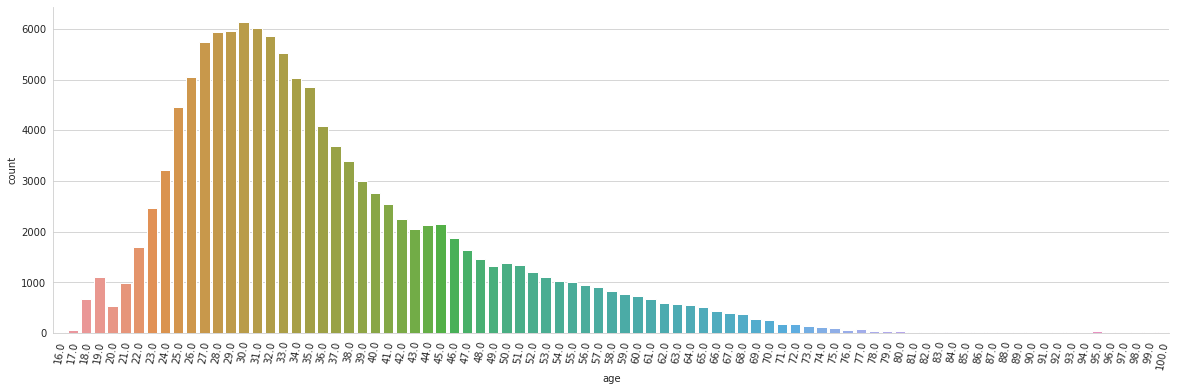

In [118]:
train.loc[train.age<16]=np.nan
train.loc[train.age>100]=np.nan

#Countplot for age
plt.figure(figsize=(20,6))
sns.countplot(train.age)
plt.xticks(rotation=80)
sns.despine()

--> Depois de remover os valores discrepantes da variável de idade, podemos traçar o gráfico acima, que está fortemente inclinado para a direita.

--> A maioria dos usuários tem idade entre 25 e 40 anos.

--> Muito poucas pessoas têm idades superiores a 50 anos. Também podemos observar que os valores de contagem diminuem à medida que o valor da idade aumenta.

--> Podemos concluir que a maioria dos usuários que reservam viagens geralmente tem entre 25 e 40 anos, enquanto as pessoas mais velhas raramente costumam viajar.

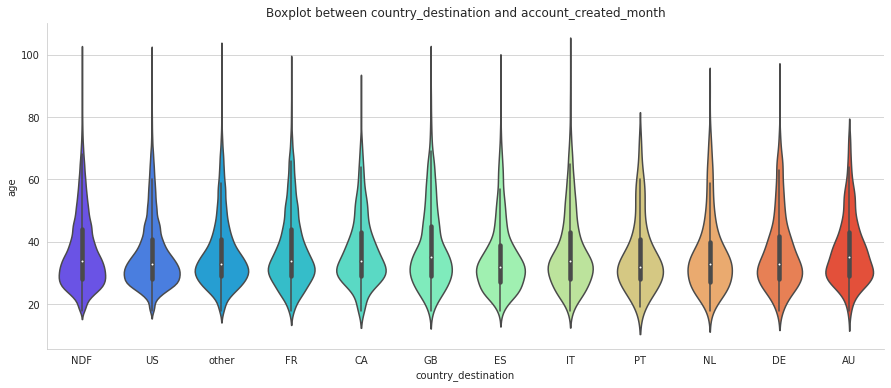

In [123]:
#Boxplot between country_destination and age
train.loc[train.age<18]=np.nan
train.loc[train.age>100]=np.nan
plt.figure(figsize=(15,6))
sns.violinplot(data=train , y='age', x='country_destination',palette='rainbow')
plt.title('Boxplot between country_destination and account_created_month')
#plt.ylim(0,100)
sns.despine()

#### signup_app

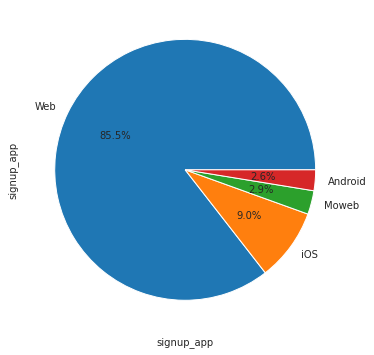

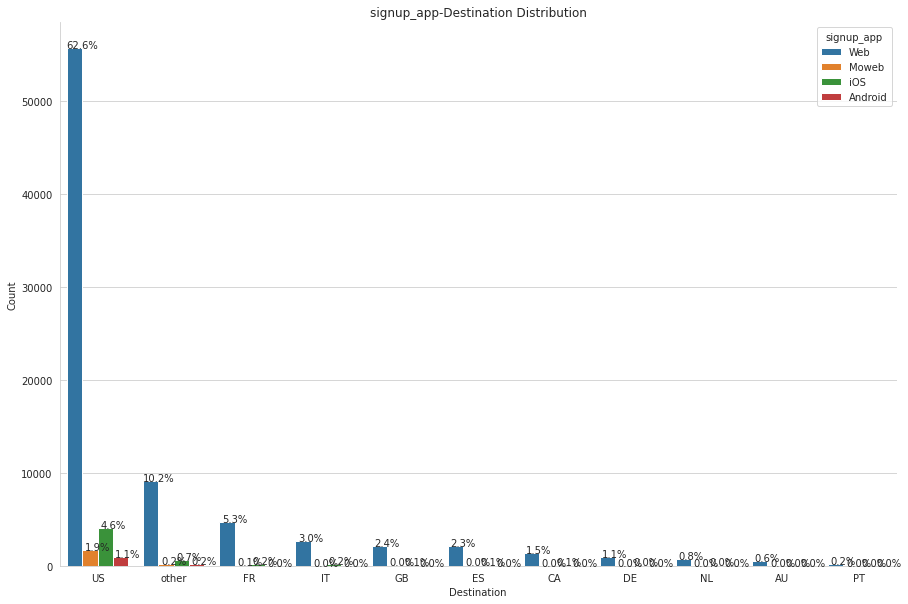

In [120]:
#Bar plot for signup_app

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
percentage = train['signup_app'].value_counts() / train.shape[0] * 100
percentage.plot(kind='pie',autopct="%1.1f%%")
plt.xlabel('signup_app')
sns.despine()

plt.figure(figsize=(15,10))
ax=sns.countplot(data = train1, x = 'country_destination', order = train1['country_destination'].value_counts().index , hue='signup_app')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('signup_app-Destination Distribution')
total = float(len(train1))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
#plt.show()
sns.despine()

--> A partir do primeiro gráfico, podemos observar que cerca de 85% dos usuários estão usando o método de inscrição como web e cerca de 9% estão usando o método de inscrição como iOS, enquanto o Android e o moweb estão tendo porcentagens muito baixas.

--> Da segunda parcela, 62% das pessoas que viajam para os EUA e têm um aplicativo de inscrição na Web, também pessoas que usam o iOS como aplicativo de inscrição, quase todas viajam para os EUA.


#### first_device_type

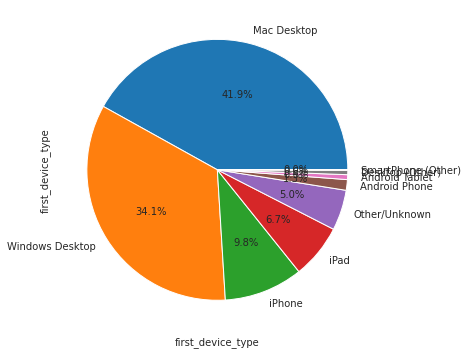

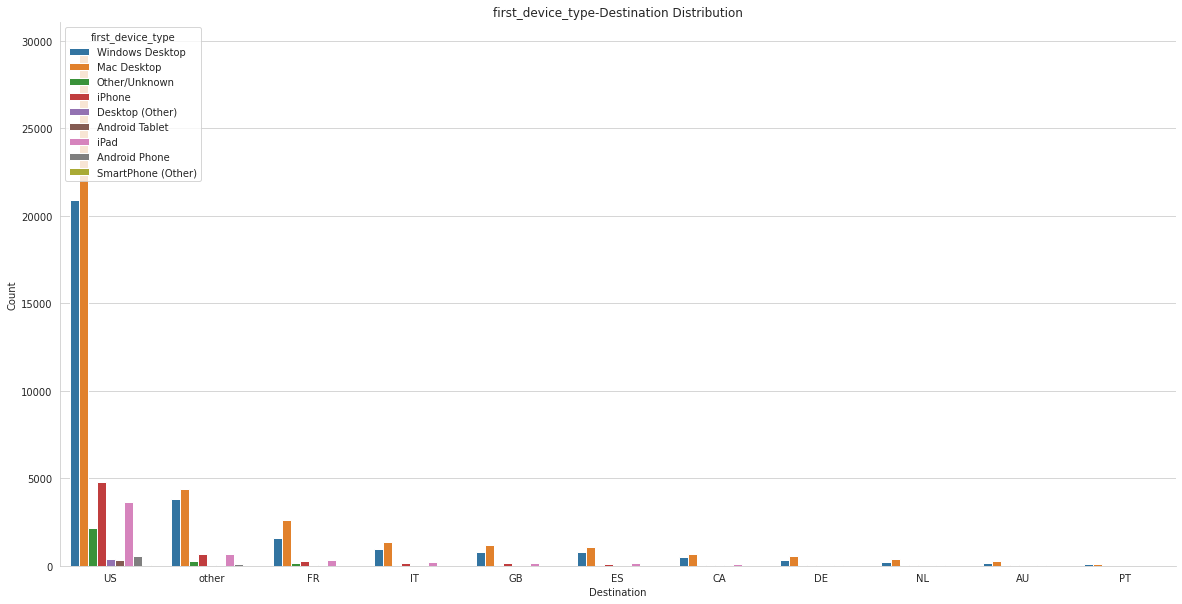

In [121]:
#Bar plot for first_device_type

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
percentage = train['first_device_type'].value_counts() / train.shape[0] * 100
percentage.plot(kind='pie',autopct="%1.1f%%")
plt.xlabel('first_device_type')
sns.despine()

plt.figure(figsize=(20,10))
ax=sns.countplot(data = train1, x = 'country_destination', order = train1['country_destination'].value_counts().index , hue='first_device_type')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('first_device_type-Destination Distribution')
sns.despine()

--> Para as pessoas que viajam para os EUA, a maioria delas tem o tipo first_device como Mac Desktop, seguido pela área de trabalho do Windows.

--> Além disso, se uma pessoa estiver usando iphone ou ipad, ela estará viajando principalmente para os EUA.

--> Nenhum dos usuários do iPhone está viajando para outros países, como TI, CA, etc, além dos EUA e outros.

Obs: Esta variavel contem muitas classes e pode ser um problema na hora da codificação, por causa da dimensionalidade, iremos reduzir usando a estrategia de agrupar as categorias inrrelevantes.

### 6.2 Bivariate Analysis

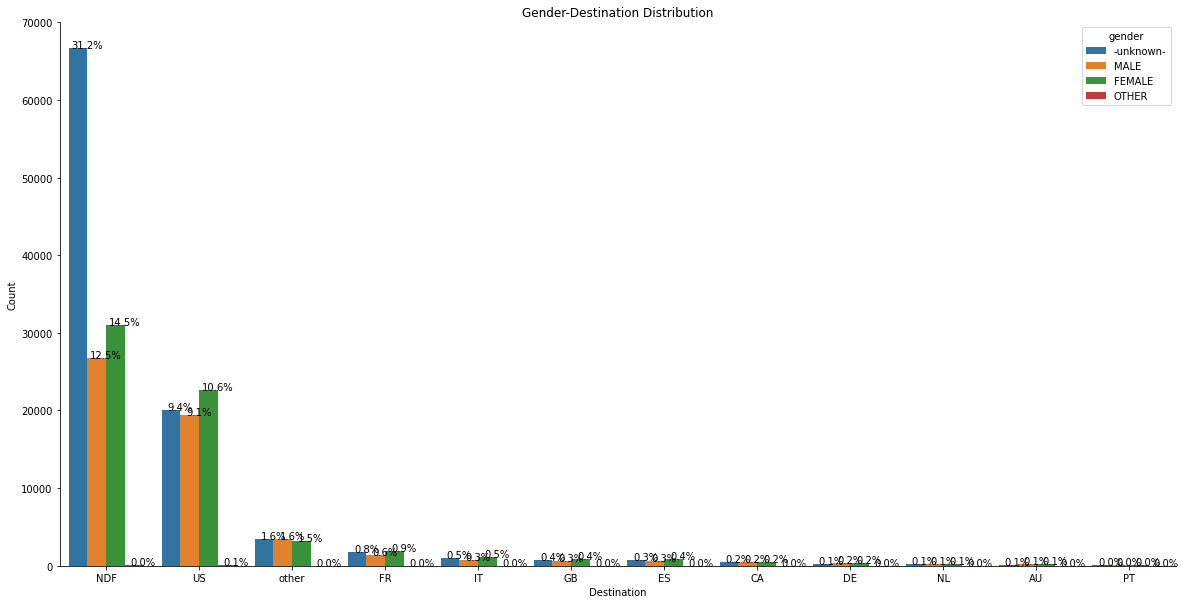

In [112]:
#Gender-Destination Distribution Plot

plt.figure(figsize=(20,10))
ax=sns.countplot(data = train, x = 'country_destination', order = train['country_destination'].value_counts().index , hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
total = float(len(train))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
sns.despine()

--> Neste grafico conseguimos verificar a distribuição por idade e por pais de destino.

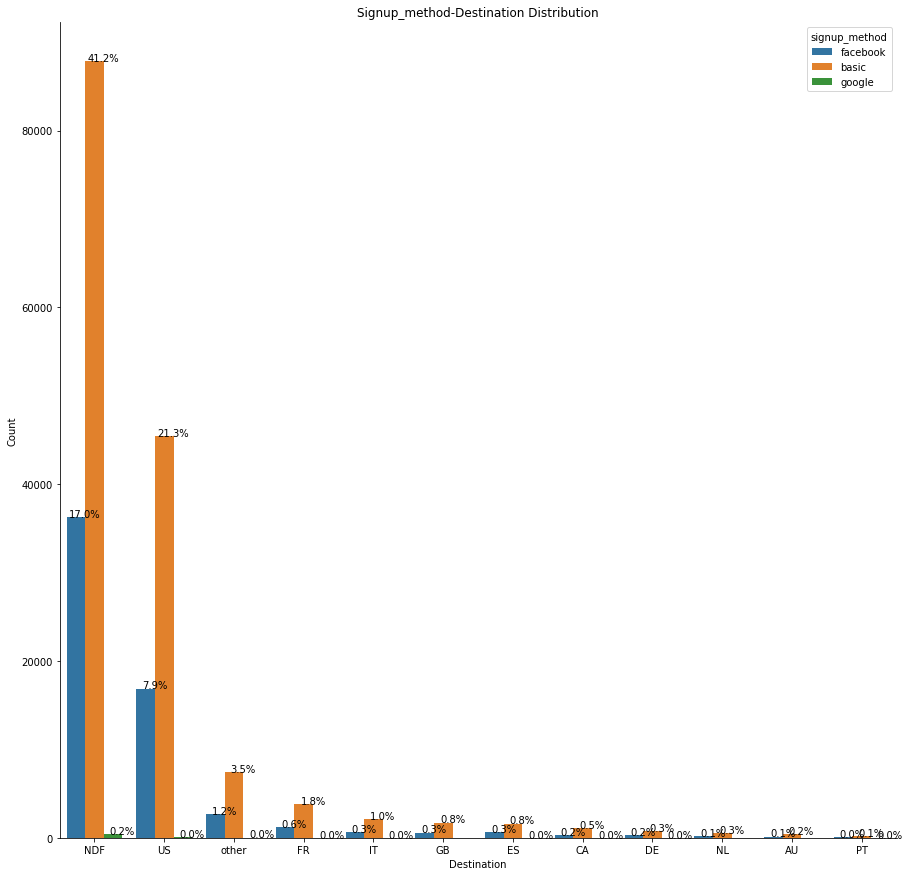

In [113]:
#Signup_method - Destination Distribution Plot

plt.figure(figsize=(15,15))
ax=sns.countplot(data = train, x = 'country_destination', order = train['country_destination'].value_counts().index , hue='signup_method')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Signup_method-Destination Distribution')
total = float(len(train))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
#plt.show()
sns.despine()

--> Metodo de incrição segue o basico seguido pelo Facebook.

<Figure size 1440x720 with 0 Axes>

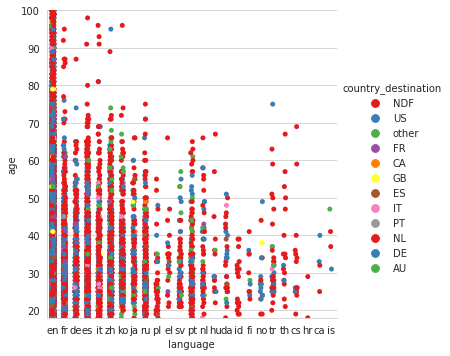

<Figure size 1440x720 with 0 Axes>

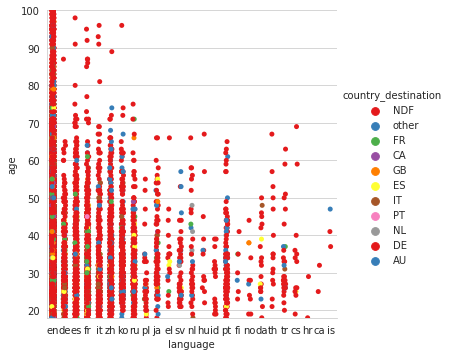

In [119]:
#language - Age Distribution Plot

plt.figure(figsize=(20,10))
sns.catplot(x="language", y="age", data=train,hue='country_destination',palette='Set1')
plt.ylim(18,100)
sns.despine()

train2=train[train['country_destination']!='US']

plt.figure(figsize=(20,10))
sns.catplot(x="language", y="age", data=train2,hue='country_destination',palette='Set1')
plt.ylim(18,100)
sns.despine()

--> No primeiro gráfico, podemos observar que as pessoas que falam inglês estão viajando para todos os países e a maioria delas está viajando para os EUA e a maioria delas tem entre 20 e 70 anos.

--> No segundo gráfico, após a remoção do rótulo de classe dos EUA, as pessoas que falam inglês têm idades variáveis.

--> As pessoas que falam a língua zh têm idades entre 22 e 40 anos ou geralmente são mais jovens e estão viajando para outros países.

In [132]:
train.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

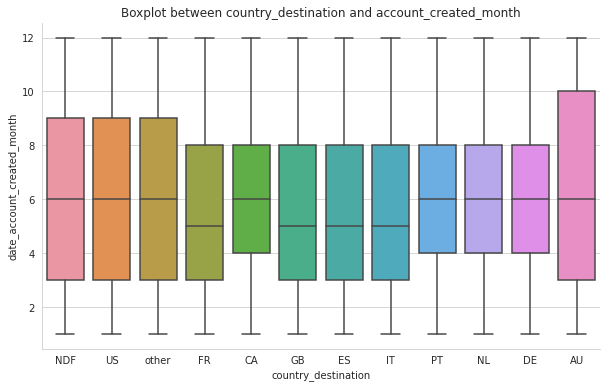

In [139]:
train.date_account_created = pd.to_datetime(train.date_account_created)
train['date_account_created_month'] = train['date_account_created'].dt.month
#Boxplot between country_destination and account_created_month

plt.figure(figsize=(10,6))
sns.boxplot(data=train , y='date_account_created_month', x='country_destination')
plt.title('Boxplot between country_destination and account_created_month')
sns.despine()

--> Acima, pode-se ver que os usuários que viajam para GB, ES, FR e IT, a maioria deles criou sua conta no início do ano.

--> Pessoas que desejam viajar para os EUA, outros, CA, PT, NL, DE, a maioria criou sua conta no meio do ano.

--> Enquanto as pessoas que viajam para AU criaram_account_month é variável de março a outubro.

--> Como conclusão, o usuário que viaja para GB, ES, FR e It está criando sua conta no início do ano.

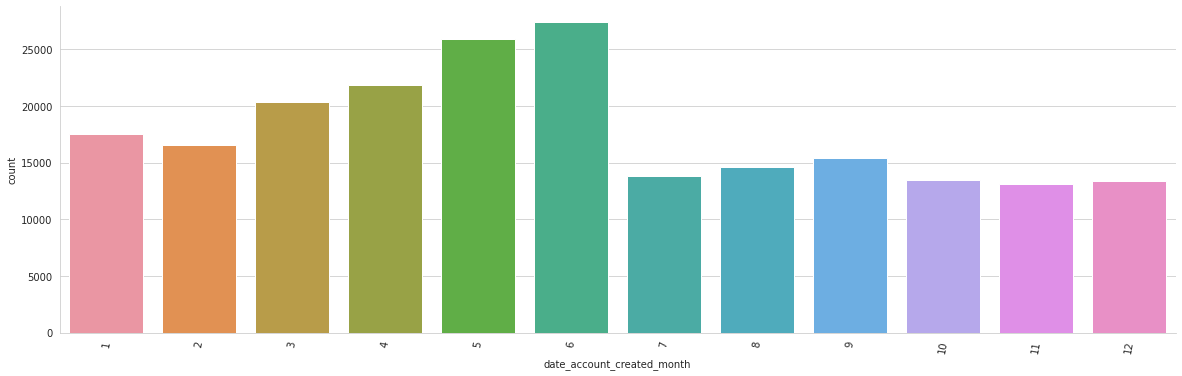

In [143]:
#Countplot for age
plt.figure(figsize=(20,6))
sns.countplot(train.date_account_created_month)
plt.xticks(rotation=80)
sns.despine()

--> Temos uma crescente mais no inicio ate o meio do ano, apois esse periodo a criação de conta cai e estabiliza.

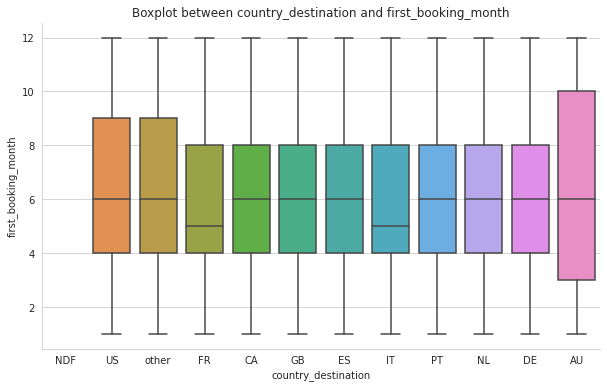

In [151]:
train.date_first_booking = pd.to_datetime(train.date_first_booking)
train['first_booking_month'] = train['date_first_booking'].dt.month

#Boxplot between country_destination and first_booking_month

plt.figure(figsize=(10,6))
sns.boxplot(data=train , y='first_booking_month', x='country_destination')
plt.title('Boxplot between country_destination and first_booking_month')
sns.despine()

--> No gráfico acima, podemos observar que as pessoas que desejam viajar para FR e IT estão fazendo suas reservas no início do ano, ou seja, a maioria delas está fazendo reservas em maio.

--> Alguns dos usuários que desejam viajar para os EUA, outros e AU também estão fazendo a primeira reserva em setembro.

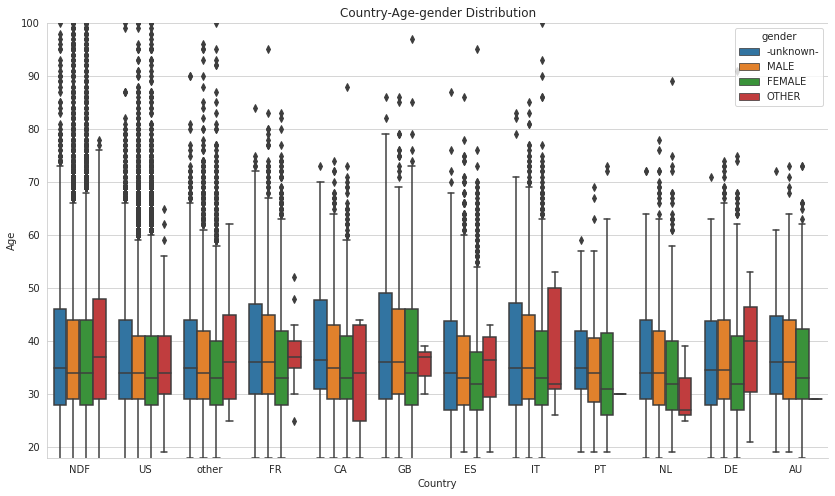

In [152]:
#Box plot between Age,Gender and Country

plt.figure(figsize=(14,8))
sns.boxplot(data=train,y='age',x='country_destination',hue='gender')
plt.ylim(18,100)
plt.xlabel('Country')
plt.ylabel('Age')
plt.title('Country-Age-gender Distribution')
sns.despine()

--> podemos observar que as usuárias mais jovens preferem viajar para países como EUA, FR, ES e PT.

--> usuárias mais velhas, algumas delas viajaram para a Grã-Bretanha.

--> Pessoas de outro sexo e mais velhas costumam reservar uma viagem para DE.

--> Pessoas de outro sexo e mais jovens geralmente reservam uma viagem para a Holanda.

--> Usuário cujo sexo é desconhecido, homem e mais velho, a maioria deles reserva uma viagem para a França.

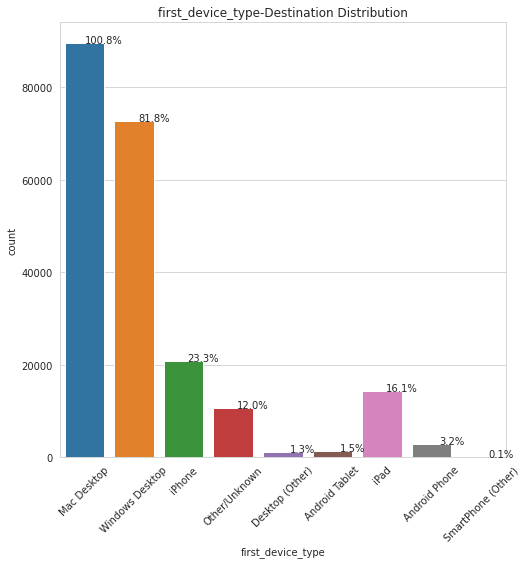

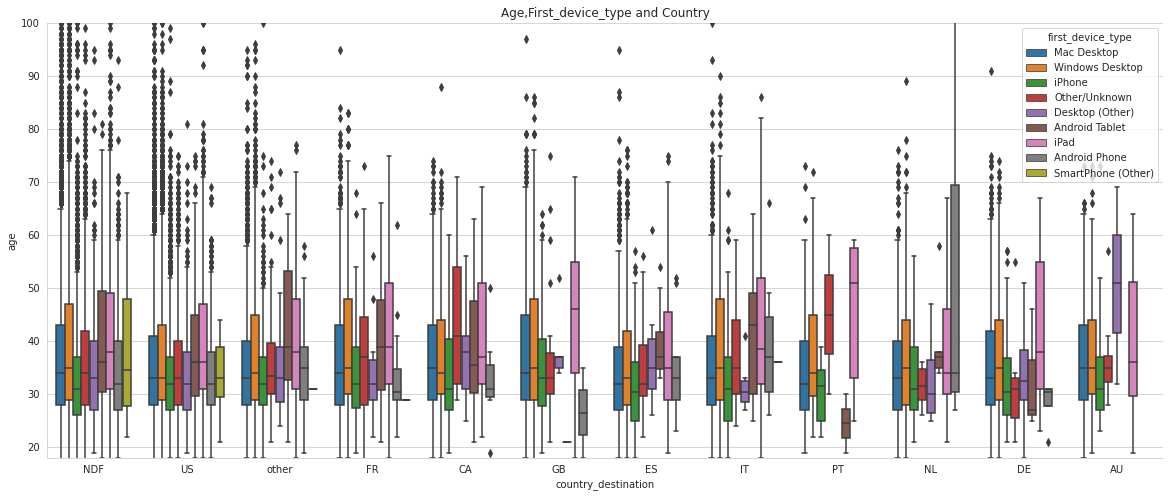

In [153]:
#Box plot between Age,First_device_type and Country

plt.figure(figsize=(8,8))
ax=sns.countplot(data = train, x = 'first_device_type' )
plt.title('first_device_type-Destination Distribution')
plt.xticks(rotation=45)
total = float(len(train1))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')


plt.figure(figsize=(20,8))
sns.boxplot(data=train,y='age',x='country_destination',hue='first_device_type')
plt.ylim(18,100)
#plt.xlabel('Country')
#plt.ylabel('Age')
plt.title('Age,First_device_type and Country')
sns.despine()

--> No primeiro gráfico, podemos ver a distribuição de first_device_type, pois a maioria dos usuários é do mac desktop seguido pelo windows dsktop, muito poucos estão usando o tipo de dispositivo android.

--> No segundo gráfico, podemos observar que, os usuários que usam o iPad como first_device_type e mais velhos geralmente reservam uma viagem para GB e PT.

--> Se um usuário estiver usando iPhone e mais jovem, reserve viagens para países como EUA, FR, CA, ES, IT e PT

--> O usuário que está usando o dispositivo como tablet Android e é mais jovem faz uma viagem para o PT.

--> O usuário que está usando o dispositivo como android e é mais jovem faz uma viagem para GB.

--> O usuário que está usando o dispositivo como Desconhecido/outro e é mais velho faz uma viagem para PT.

Obs: Temos algumas classes com pouca relevancia, iremos tratar para diminuir a dimensionalidade do dataset.

### 6.3 Validação das Hipóteses

### 6.4 Resumo Hipóteses